In [1]:
import time, datetime
str_format = '%Y%m%d%H%M%S'
readable_format = '%Y/%m/%d %H:%M:%S'

import numpy
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms


data_dir = './data/'
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
n = 28 # pixel nxn
N = n*n


In [2]:
def default_func(X,Y):
    X=X.reshape([-1,N])

    label = X
    return X,label

##Maybe this should be a parent class that all models inheret from
class Autoencoder(nn.Module):
    def __init__(self, name='autoencoder', epoch = 0):
        #nxn,N 28x28, 784
        super().__init__()

        self.name = name
        self.epoch  = epoch
        self.z_mu = None
        self.z_sigma = None

        self.encoder = nn.Sequential(
                                      nn.Linear(N, 128), # N=784 --> 128
                                      nn.ReLU(),
                                      nn.Linear(128, 64),
                                      nn.ReLU(),
                                      nn.Linear(64, 12),
                                      nn.ReLU(),
                                      nn.Linear(12, 3)
                                     )

        self.decoder = nn.Sequential(
                                      nn.Linear(3, 12), # N=784 --> 128
                                      nn.ReLU(),
                                      nn.Linear(12, 64),
                                      nn.ReLU(),
                                      nn.Linear(64, 128),
                                      nn.ReLU(),
                                      nn.Linear(128, N),
                                      nn.Sigmoid() #output is in the format of [0,1]

                                     )

    def forward(self, x):

        x = self.encoder(x)
        x = self.decoder(x)

        return x



    def save_model(self, epoch=None, optimizer=None, path= f'./data/checkoint.pth'):
        '''This method saves the model parameters to a .pth file given a file path'''

        self.optimizer = optimizer if optimizer else self.optimizer
        self.epoch = epoch if epoch else self.epoch

        torch.save({
                     'epoch': self.epoch,
                     'model_state_dict': self.state_dict(),
                     'optimizer_state_dict': self.optimizer.state_dict(),
        }, path)

        return path


    def load_model(self, loss_fn, optimizer,  path):
        '''This method loads the model parameters to a .pth file given a file path'''

        self.optimizer = optimizer
        self.loss_fn = loss_fn

        checkpoint = torch.load(path)

        self.load_state_dict(checkpoint['model_state_dict'])

        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epoch = checkpoint['epoch']

        return self

    def train_step(self, dataloader,func = default_func, loss_fn=None, optimizer=None):

        self.loss_fn = loss_fn if loss_fn else self.loss_fn
        self.optimizer = optimizer if optimizer else self.optimizer

        size = len(dataloader.dataset)

        self.train()

        self.epoch += 1

        for batch, (X,Y) in enumerate(dataloader):

            X = X.to(device)

            X, label = func(X,Y)  #insert data transformation function and label configuration

            #Inference
            out = self(X)

            loss = self.loss_fn(out, label)

            #Backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if batch % 100 == 0:
                loss, current = loss.item(), (batch +1)*len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    def test_step(self, dataloader, func = default_func, loss_fn =None):
        self.loss_fn = loss_fn if loss_fn else self.loss_fn

        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        self.eval()
        test_loss, correct = 0,0

        ###### POTENTIAL DECORATOR FUNCTION
        with torch.no_grad():
            for X, Y in dataloader:
                X = X.to(device)

                X, label = func(X,Y) #insert data transformation function and label configuration
                # inference
                out = self(X)
                test_loss += self.loss_fn(out, label).item()

            test_loss /= num_batches
            print(f"Test Error: \nAvg loss: {test_loss:>8f} \n")

        return X, out


    def train_model(self, train_data_loader, test_data_loader, num_epochs = 5, data_label_func = default_func):

        results=[]

        for epoch in range(self.epoch, self.epoch+num_epochs):
            print( f'Epoch {epoch+1}\n-----------------------------')
            self.train_step(dataloader=train_data_loader,func = data_label_func)
            img, recon = self.test_step(dataloader=test_data_loader, func = data_label_func)
            results.append((epoch,img,recon))

        return results

In [3]:
#### Import and Initialize Data
print(f'Using {device} device')

transform = transforms.ToTensor()

training_data = datasets.MNIST( root ='./data',
                            train = True,
                            download = True,
                            transform = transform)

testing_data = datasets.MNIST( root ='./data',
                            train = True,
                            download = False,
                            transform = transform)

train_data_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=64, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(dataset=testing_data, batch_size=64, shuffle=True)

Using cuda device


In [4]:
#### Load Model

model = Autoencoder().to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr =.001, weight_decay =.00001 )


model.load_model(loss_fn, optimizer,  path='./data/20230227222800-autoencoder_checkpoint.pth')

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
  (loss_fn): MSELoss()
)

In [5]:
#### Training Loop

num_epochs = 3

results = model.train_model(train_data_loader, test_data_loader, num_epochs)

ts = datetime.datetime.now().strftime(str_format)
filepath = f'{data_dir}{ts}-{model.name}_checkpoint.pth'

model.save_model(optimizer=optimizer, path=filepath)

Epoch 5
-----------------------------
loss: 0.032635  [   64/60000]
loss: 0.034503  [ 6464/60000]
loss: 0.034265  [12864/60000]
loss: 0.034793  [19264/60000]
loss: 0.031611  [25664/60000]
loss: 0.034393  [32064/60000]
loss: 0.036604  [38464/60000]
loss: 0.035537  [44864/60000]
loss: 0.032233  [51264/60000]
loss: 0.035727  [57664/60000]
Test Error: 
Avg loss: 0.033896 

Epoch 6
-----------------------------
loss: 0.034841  [   64/60000]
loss: 0.035177  [ 6464/60000]
loss: 0.035654  [12864/60000]
loss: 0.033053  [19264/60000]
loss: 0.033069  [25664/60000]
loss: 0.033839  [32064/60000]
loss: 0.033340  [38464/60000]
loss: 0.031830  [44864/60000]
loss: 0.035232  [51264/60000]
loss: 0.032612  [57664/60000]
Test Error: 
Avg loss: 0.033560 

Epoch 7
-----------------------------
loss: 0.034049  [   64/60000]
loss: 0.034622  [ 6464/60000]
loss: 0.035616  [12864/60000]
loss: 0.034712  [19264/60000]
loss: 0.035582  [25664/60000]
loss: 0.032276  [32064/60000]
loss: 0.034434  [38464/60000]
loss: 0.

'./data/20230305172153-autoencoder_checkpoint.pth'

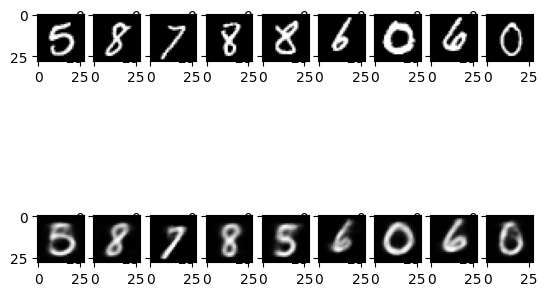

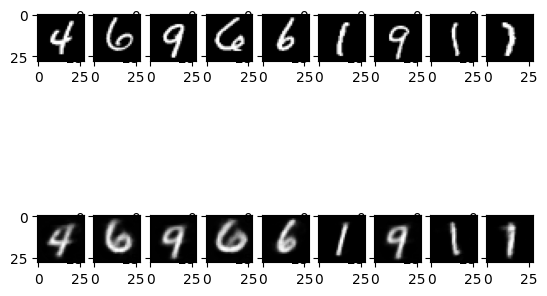

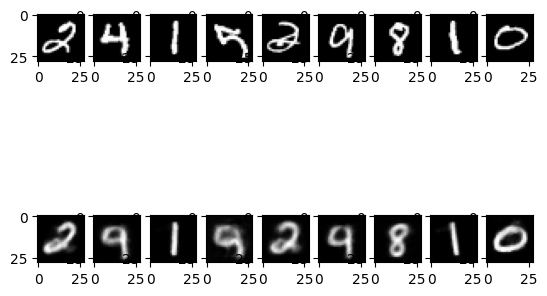

done


In [ ]:
### Plot Results

figure = []
for k in range(0,len(results)):

    figure.append((k,plt.figure()))
    plt.gray()

    imgs = results[k][1].reshape([-1,28,28])
    recons = results[k][2].reshape([-1,28,28])

    imgs = imgs.cpu().detach().numpy()
    recons = recons.cpu().detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2,9,i+1)
        plt.imshow(item)

    for i, item in enumerate(recons):
        if i>=9:break
        plt.subplot(2,9,9+i+1)
        plt.imshow(item)


plt.show()


print('done')